# Segmentación de imágenes mediante un modelo Unet

## Aprendizaje Máquina I

### Esteban Reyes Saldaña

En esta tarea se implementaron tres modelos para segmentar imágenes.

1. https://www.tensorflow.org/tutorials/images/segmentation  
2. https://keras.io/examples/vision/oxford_pets_image_segmentation/
3. http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/unet/unet_segmentacion.html

usando la base de datos de imágenes de mascotas que se puede consultar en https://www.robots.ox.ac.uk/~vgg/data/pets/

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-f2onssky
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-f2onssky
  Created wheel for tensorflow-examples: filename=tensorflow_examples-49190180a20bc5fdbcf7a67125b5be32bd2dd784_-cp37-none-any.whl size=265248 sha256=83322c676b8818def731cbdc417441a737fecfe6faacc890e7058680985c8b28
  Stored in directory: /tmp/pip-ephem-wheel-cache-0qh3ahr_/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


# Librerías

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.optimizers as optimizers
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, add
from tensorflow.keras.layers import MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Reshape, SeparableConv2D
from tensorflow.keras.layers import Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential

# Descargamos datos

In [ ]:
data, info = tfds.load('oxford_iiit_pet:3.*.*', with_info = True)

# Preparamos paths de las imágenes de entrada y objetivo para máscaras de segmentación

In [ ]:
# Normalizamos datos
def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.
    mask -= 1
    return image, mask

@tf.function
def load_image_train(data):
    input_image = tf.image.resize(data['image'], (128, 128))
    input_mask  = tf.image.resize(data['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask  = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(data):
    input_image = tf.image.resize(data['image'], (128, 128))
    input_mask = tf.image.resize(data['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Parámetros

In [ ]:
samples     = info.splits['train'].num_examples
epochs      = 50
channels    = 3
img_size    = (128,128, 3)
batch_size  = 128
buffer_size = 1000
num_classes = 3
steps_per_epoch = samples // batch_size

# Cargamos batches

In [ ]:
train_set = data['train'].map(load_image_train, num_parallel_calls = tf.data.AUTOTUNE)
test_set  = data['test'].map(load_image_test)

In [ ]:
train_dataset = train_set.cache().shuffle(buffer_size).batch(batch_size).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset  = test_set.batch(batch_size)

# Mostramos un ejemplo (image y máscara)

In [ ]:
def display(image_list):
    plt.figure(figsize=(8, 8))
    title = ['Input', 'Target Mask', 'Optput Mask']
    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]))
        plt.axis('off')
    plt.show()

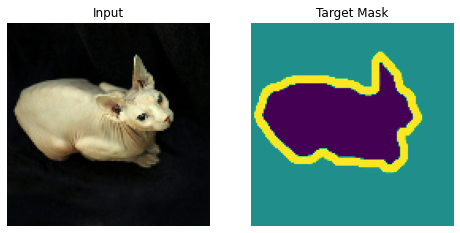

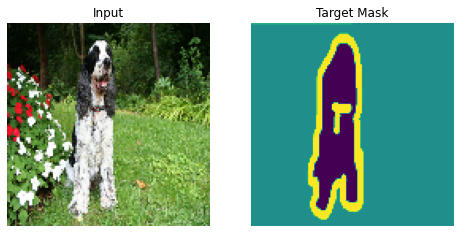

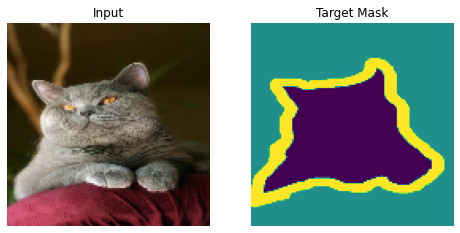

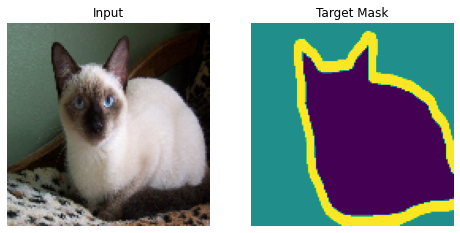

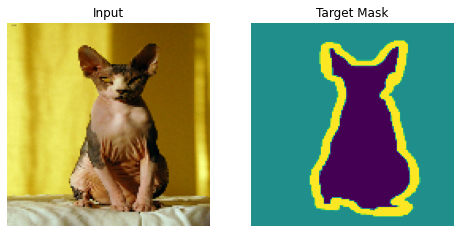

In [ ]:
for image, mask in train.take(5):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

# Modelo de Tensorflow

Este codificador es un modelo MobileNetV2 previamente entrenado. El codificador consta de salidas específicas de capas intermedias en el modelo. El codificador se congelará para el entrenamiento.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = [128, 128, 3], include_top = False)

# Use the activations of these layers
layer_names = ['block_1_expand_relu',   # 64x64
               'block_3_expand_relu',   # 32x32
               'block_6_expand_relu',   # 16x16
               'block_13_expand_relu',  # 8x8
               'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = Model(inputs = base_model.input, outputs = base_model_outputs)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def tf_unet_model(img_size, channels):
    inputs = Input(shape = img_size)

    # Downsampling through the model
    skips = down_stack(inputs)
    x     = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    # This is the last layer of the model
    last = Conv2DTranspose(filters     = channels,
                           kernel_size = 3, 
                           strides     = 2,
                           padding     = 'same')
    x = last(x)

    return Model(inputs = inputs, outputs = x, name='TF_unet_model')

In [ ]:
tf_model = tf_unet_model(img_size, channels)
tf_model.summary()

Model: "TF_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_7[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[1][0]                 
                                                                 model[1][3]          

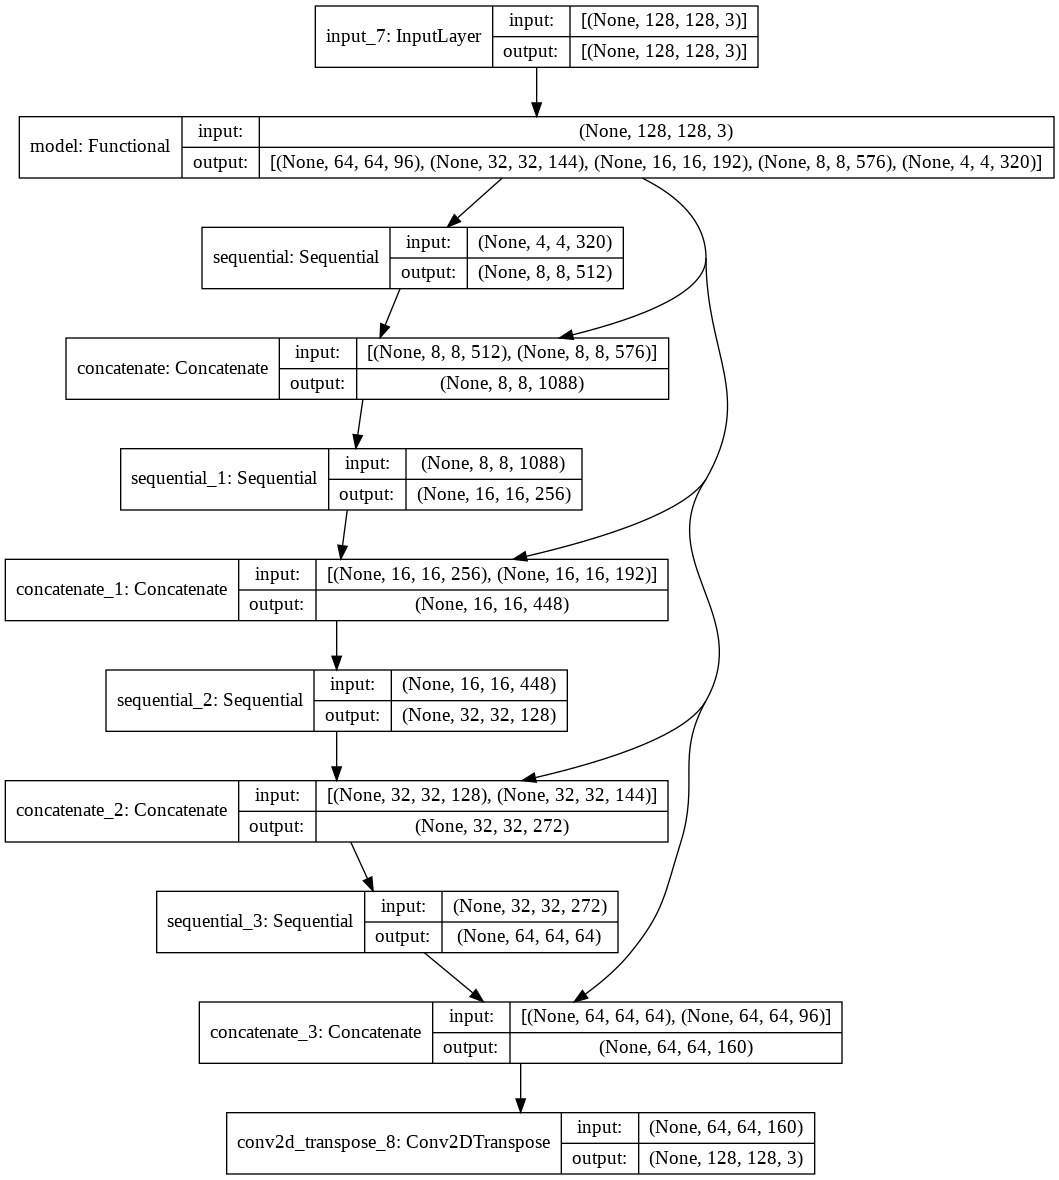

In [ ]:
plot_model(tf_model, show_shapes=True)

## Mostramos máscaras sin entrenar

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis = -1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(model, dataset = None, index = 1):
    for image, mask in dataset.take(index):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

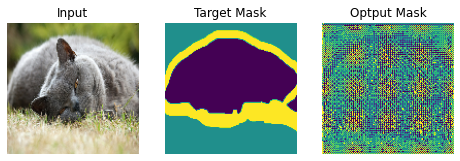

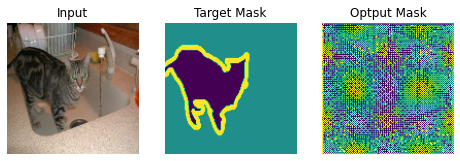

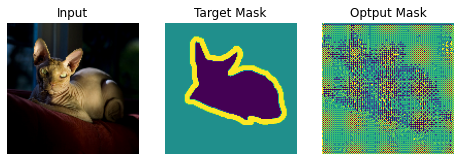

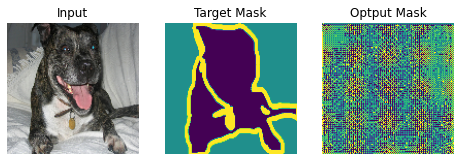

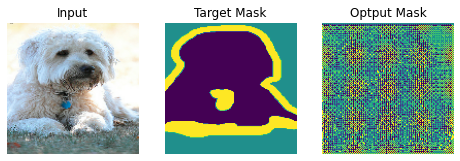

In [ ]:
show_predictions(tf_model, train_dataset, index = 5)

# Modelo de Keras

In [ ]:
def keras_unet_model(img_size, num_classes):
    inputs = Input(shape=img_size)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(2)(x)

        # Project residual
        residual = UpSampling2D(2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding="same")(residual)
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs, name='K_unet')
    return model

In [ ]:
keras.backend.clear_session()

keras_model = keras_unet_model(img_size, num_classes)
keras_model.summary()

Model: "K_unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
_____________________________________________________________________________________________

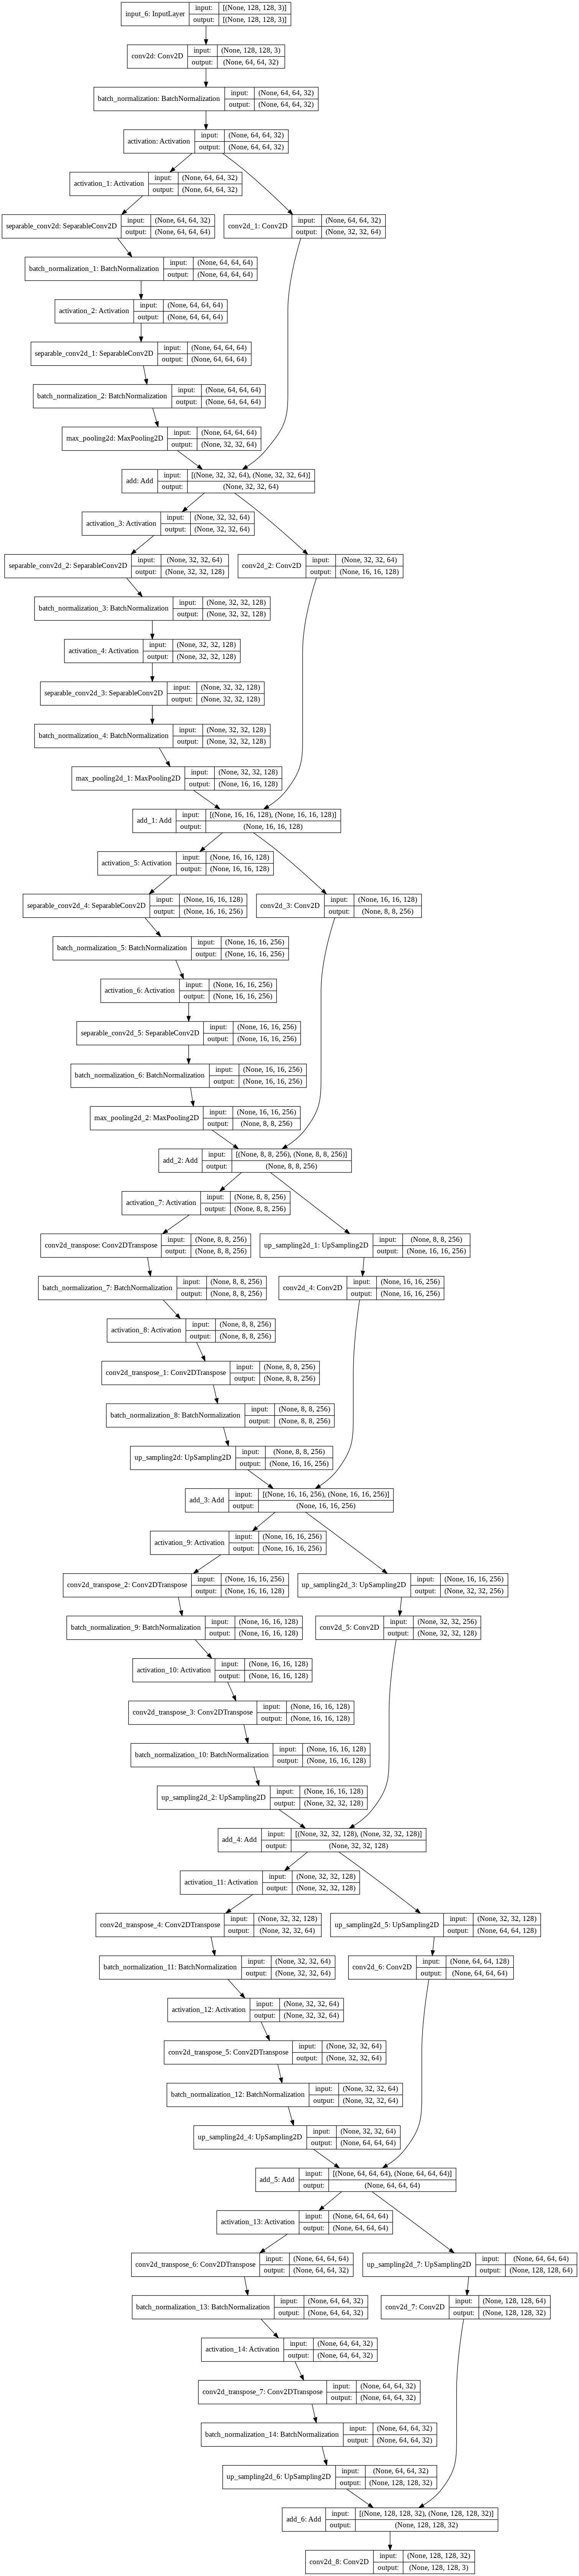

In [ ]:
plot_model(keras_model, show_shapes=True)

# Implementación de Unet de Notas

Este modelo está basada en la UNet de 
http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/unet/unet_segmentacion.html.

In [ ]:
def mariano_unet_model(img_size, channels):
    filters_per_block = np.array([channels, 64, 128, 256])
    num_blocks        = len(filters_per_block)
    kernel_size       = (3, 3)
    drop              = 0.25*np.ones(num_blocks)

    nm    = 'encoder'
    Xdicc = {}
    Xin   = Input(shape=img_size, name="x_true")
    Xdicc[0] = Xin
    numFilters = filters_per_block[0]
    print(0, numFilters, Xin.shape)

    X = Xin
    for i in range(1,num_blocks):
        numFilters=filters_per_block[i]
        X = Conv2D(numFilters, kernel_size=kernel_size, padding='same', activation='relu', name='encoder-conv1'+str(i))(X) 
        X = Conv2D(numFilters, kernel_size=kernel_size, padding='same', activation='relu', name='encoder-conv2'+str(i))(X)
        X = Dropout(rate=drop[i], name='encoder-drop'+str(i))(X)
        X = MaxPooling2D(pool_size=(2,2), padding='valid', name='encoder-maxpool'+str(i))(X)
        Xdicc[i] = X
        print(i, numFilters, Xdicc[i].shape)
    
    Y = X
    for i in range(num_blocks-1,0,-1):
        if i>1:
            numFilters = filters_per_block[i-1] 
        else:
            numFilters = 32
        #print(i, numFilters, Y.shape, Xdicc[i-1].shape)
        Y = UpSampling2D(size=2, name='decoder-up'+str(i))(Y)  
        print(i, numFilters, Y.shape, Xdicc[i-1].shape)
        Y = Concatenate(name='decoder-concat'+str(i))([Y, Xdicc[i-1]])
        Y = Conv2D(numFilters, kernel_size=(3,3), padding='same', activation='relu', name='decoder-conv2'+str(i))(Y)
        Y = Conv2D(numFilters, kernel_size=(3,3), padding='same', activation='relu', name='decoder-conv3'+str(i))(Y)
        Y = Dropout(rate=drop[i], name='decoder-drop'+str(i))(Y)
    
    # output layers
    Y = Conv2D(3, kernel_size=(3,3), 
            padding='same', 
            activation=None,
            name='tail-2xch')(Y)
    
    unet_model = Model(inputs=Xin, outputs=Y, name='Notas_Unet')
    return unet_model

In [ ]:
mariano_model = mariano_unet_model(img_size, channels)
mariano_model.summary()

0 3 (None, 128, 128, 3)
1 64 (None, 64, 64, 64)
2 128 (None, 32, 32, 128)
3 256 (None, 16, 16, 256)
3 128 (None, 32, 32, 256) (None, 32, 32, 128)
2 64 (None, 64, 64, 128) (None, 64, 64, 64)
1 32 (None, 128, 128, 64) (None, 128, 128, 3)
Model: "Notas_Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder-conv11 (Conv2D)         (None, 128, 128, 64) 1792        x_true[0][0]                     
__________________________________________________________________________________________________
encoder-conv21 (Conv2D)         (None, 128, 128, 64) 36928       encoder-conv11[0][0]             
___________________________________________________

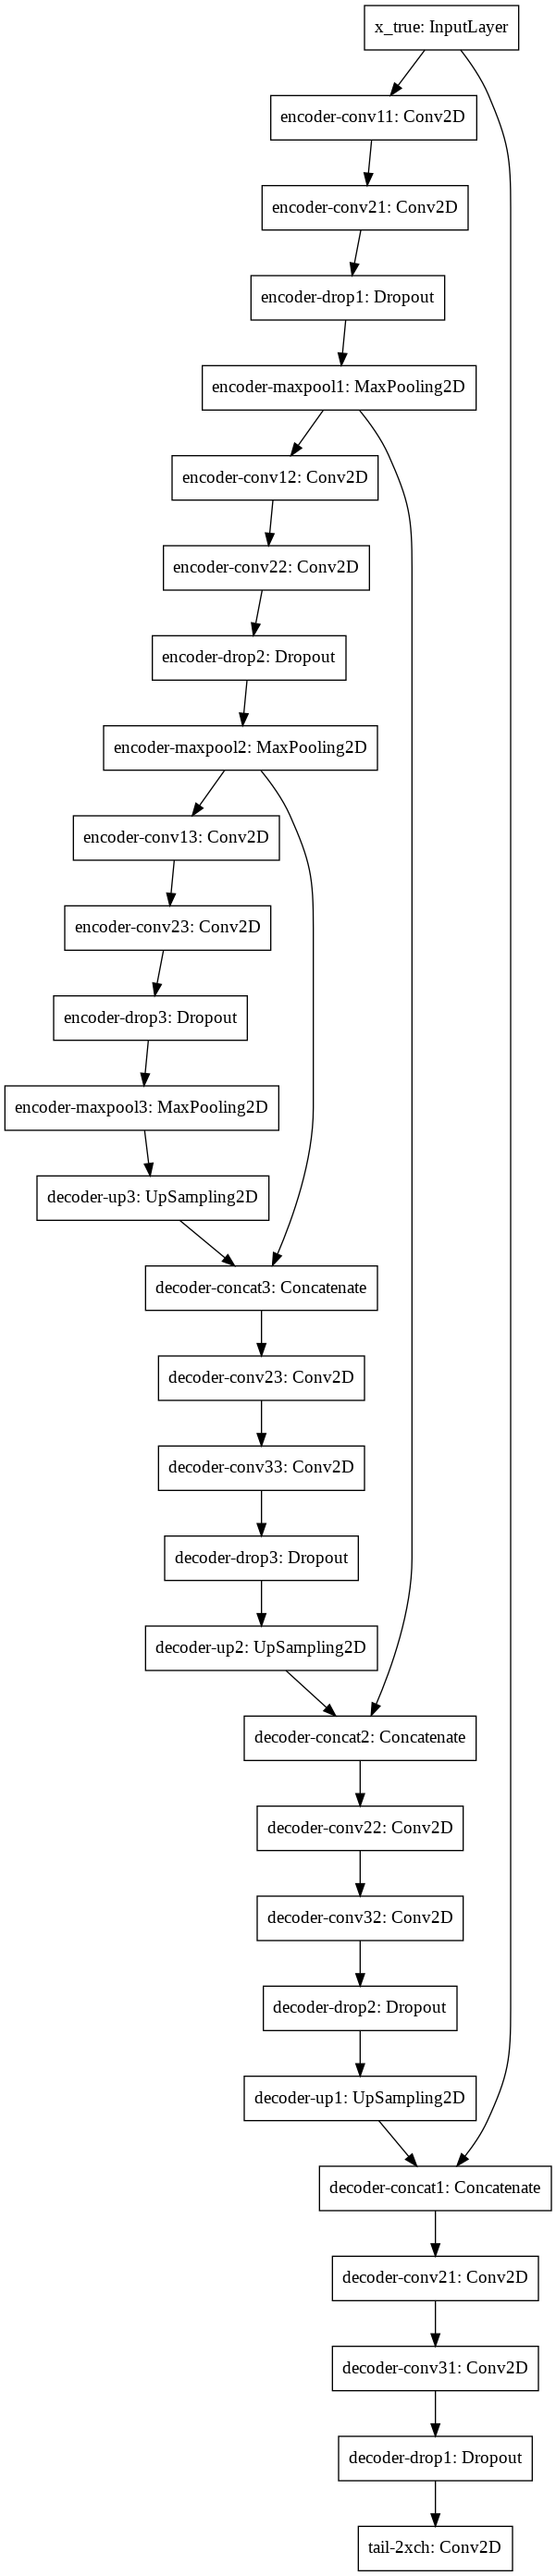

In [ ]:
plot_model(mariano_model)

# Entrenamiento de los modelos

## modelo tensorflow

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
tf_model.compile(optimizer = "rmsprop", 
                 loss      = "sparse_categorical_crossentropy",
                 metrics   = ['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("tf_segmentation.h5", save_best_only=True)
]

VAL_SUBSPLITS    = 5
VALIDATION_STEPS = info.splits['test'].num_examples//batch_size//VAL_SUBSPLITS
# Train the model, doing validation at the end of each epoch0.
tf_history = tf_model.fit(train_dataset, 
                          epochs           = epochs, 
                          steps_per_epoch  = steps_per_epoch,
                          validation_steps = VALIDATION_STEPS,
                          validation_data  = test_dataset, 
                          callbacks        = callbacks)

Epoch 1/50
28/28 [==============================] - 18s 384ms/step - loss: 1.7370 - accuracy: 0.4443 - val_loss: 1.6881 - val_accuracy: 0.4115


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
28/28 [==============================] - 10s 284ms/step - loss: 1.1739 - accuracy: 0.4875 - val_loss: 1.5397 - val_accuracy: 0.4438
Epoch 3/50
28/28 [==============================] - 8s 283ms/step - loss: 0.9956 - accuracy: 0.5047 - val_loss: 1.0707 - val_accuracy: 0.5672
Epoch 4/50
28/28 [==============================] - 8s 286ms/step - loss: 0.9639 - accuracy: 0.5270 - val_loss: 0.9252 - val_accuracy: 0.5513
Epoch 5/50
28/28 [==============================] - 8s 285ms/step - loss: 0.8488 - accuracy: 0.5632 - val_loss: 0.8798 - val_accuracy: 0.5813
Epoch 6/50
28/28 [==============================] - 8s 286ms/step - loss: 0.7825 - accuracy: 0.6058 - val_loss: 0.8816 - val_accuracy: 0.6214
Epoch 7/50
28/28 [==============================] - 8s 286ms/step - loss: 0.7748 - accuracy: 0.6508 - val_loss: 1.0891 - val_accuracy: 0.6177
Epoch 8/50
28/28 [==============================] - 8s 287ms/step - loss: 0.7703 - accuracy: 0.6703 - val_loss: 1.1794 - val_accuracy: 0.6705
Epoch

## modelo keras

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
keras_model.compile(optimizer = "rmsprop", 
                    loss      = "sparse_categorical_crossentropy", 
                    metrics   = ['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("keras_segmentation.h5", save_best_only = True)
]

# Train the model, doing validation at the end of each epoch.
keras_history = keras_model.fit(train_dataset, 
                                epochs           = epochs, 
                                steps_per_epoch  = steps_per_epoch,
                                validation_steps = VALIDATION_STEPS,
                                validation_data  = test_dataset,
                                callbacks        = callbacks)

Epoch 1/50
28/28 [==============================] - 24s 585ms/step - loss: 2.2740 - accuracy: 0.6246 - val_loss: 5.2433 - val_accuracy: 0.5613
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


28/28 [==============================] - 19s 573ms/step - loss: 0.7559 - accuracy: 0.6996 - val_loss: 4.2942 - val_accuracy: 0.5656
Epoch 3/50
28/28 [==============================] - 16s 559ms/step - loss: 0.7424 - accuracy: 0.7022 - val_loss: 4.3870 - val_accuracy: 0.5658
Epoch 4/50
28/28 [==============================] - 15s 550ms/step - loss: 0.6625 - accuracy: 0.7278 - val_loss: 6.9424 - val_accuracy: 0.5658
Epoch 5/50
28/28 [==============================] - 15s 551ms/step - loss: 0.6037 - accuracy: 0.7509 - val_loss: 2.1570 - val_accuracy: 0.5588
Epoch 6/50
28/28 [==============================] - 16s 560ms/step - loss: 0.5581 - accuracy: 0.7664 - val_loss: 3.3335 - val_accuracy: 0.5658
Epoch 7/50
28/28 [==============================] - 16s 563ms/step - loss: 0.5241 - accuracy: 0.7822 - val_loss: 2.4167 - val_accuracy: 0.5658
Epoch 8/50
28/28 [==============================] - 16s 558ms/step - loss: 0.4883 - accuracy: 0.7976 - val_loss: 2.6049 - val_accuracy: 0.5658
Epoch 9/50

## modelo Mariano

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
mariano_model.compile(optimizer = "rmsprop",
                      loss      = "sparse_categorical_crossentropy",
                      metrics   = ['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("notas_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
mariano_history = mariano_model.fit(train_dataset, 
                                    epochs           = epochs, 
                                    steps_per_epoch  = steps_per_epoch,
                                    validation_steps = VALIDATION_STEPS,
                                    validation_data  = test_dataset,
                                    callbacks        = callbacks)

Epoch 1/50
28/28 [==============================] - 41s 867ms/step - loss: 1.1982 - accuracy: 0.4658 - val_loss: 0.9408 - val_accuracy: 0.5612
Epoch 2/50
28/28 [==============================] - 39s 840ms/step - loss: 0.9305 - accuracy: 0.5790 - val_loss: 0.9791 - val_accuracy: 0.5658
Epoch 3/50
28/28 [==============================] - 23s 837ms/step - loss: 0.9325 - accuracy: 0.5812 - val_loss: 0.9548 - val_accuracy: 0.5650
Epoch 4/50
28/28 [==============================] - 24s 845ms/step - loss: 0.9728 - accuracy: 0.5786 - val_loss: 0.8795 - val_accuracy: 0.5658
Epoch 5/50
28/28 [==============================] - 23s 841ms/step - loss: 0.8350 - accuracy: 0.6003 - val_loss: 0.9228 - val_accuracy: 0.4900
Epoch 6/50
28/28 [==============================] - 23s 837ms/step - loss: 0.7978 - accuracy: 0.6391 - val_loss: 0.7242 - val_accuracy: 0.7017
Epoch 7/50
28/28 [==============================] - 23s 838ms/step - loss: 0.7691 - accuracy: 0.6716 - val_loss: 0.7125 - val_accuracy: 0.6945

# Gráficas

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_metrics (history) :
  acc      = history.history['accuracy']
  val_acc  = history.history['val_accuracy']
  loss     = history.history['loss']
  val_loss = history.history['val_loss']

  epochs   = range(1, len(acc) + 1)

  plt.figure(figsize=(15,7))

  plt.subplot(121)
  plt.plot(epochs, acc,     'r', label='Entrenamiento')
  plt.plot(epochs, val_acc, 'g',  label='Validacion')
  plt.title('Precisión (accuracy) de Entrenamiento y Validación')
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs, loss,     'r', label='Entrenamiento')
  plt.plot(epochs, val_loss, 'g',  label='Validación')
  plt.title('Pérdida de Entrenamiento y Validación')
  plt.legend()

  plt.show()

## Modelo tensorflow

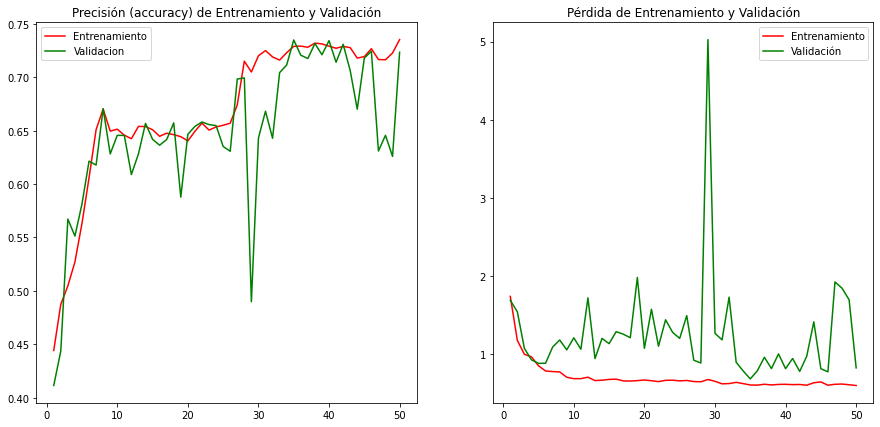

In [ ]:
plot_metrics(tf_history)

## Modelo Keras

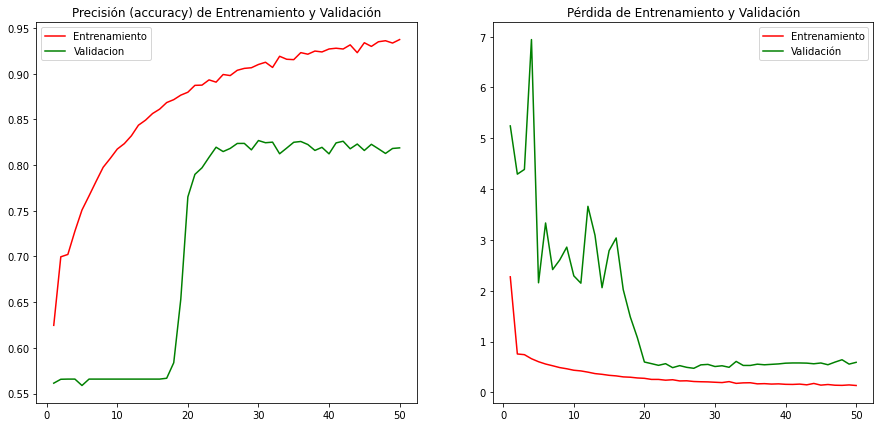

In [ ]:
plot_metrics(keras_history)

# Modelo Notas

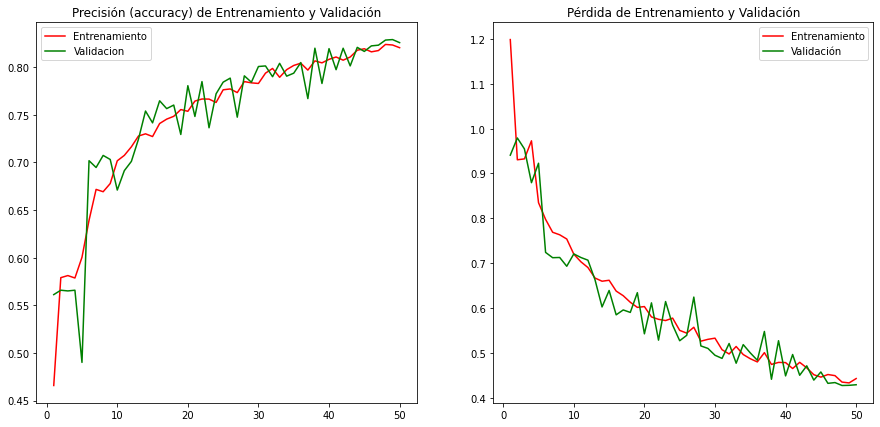

In [ ]:
plot_metrics(mariano_history)

# Vizualizamos Predicciones

# Modelo tensorflow

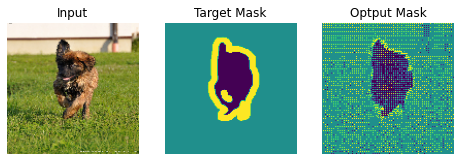

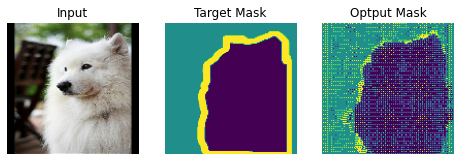

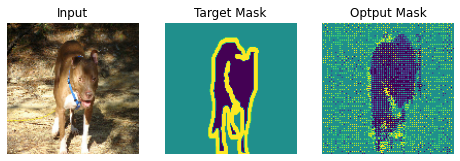

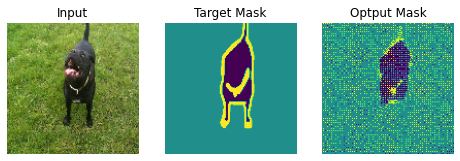

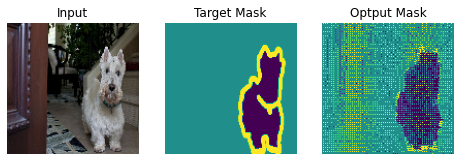

In [ ]:
show_predictions(tf_model, test_dataset, 5)

# Modelo keras

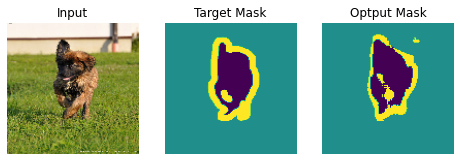

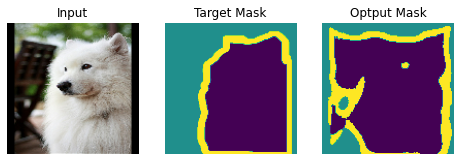

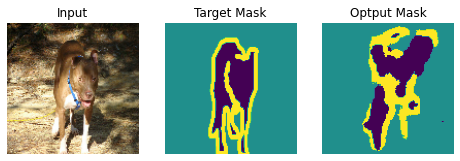

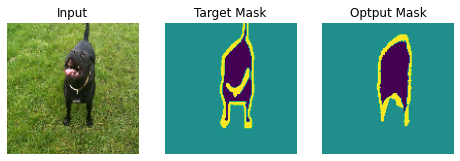

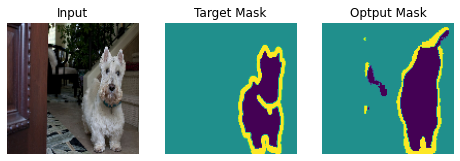

In [ ]:
show_predictions(keras_model, test_dataset, 5)

# Modelo Notas

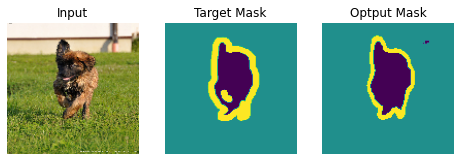

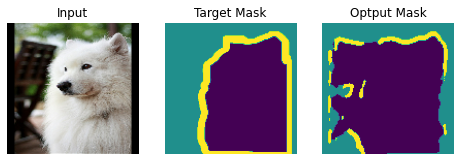

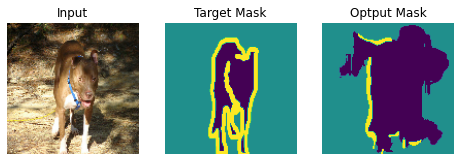

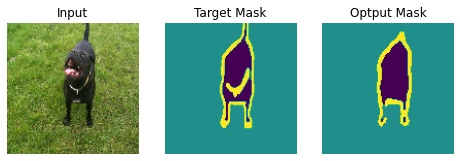

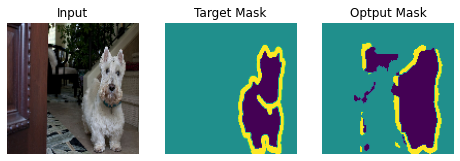

In [ ]:
show_predictions(mariano_model, test_dataset, 5)

# Conclusiones

1. ¿Cuál es la precisión en el conjunto de prueba para cada modelo?

In [1]:
import pandas as pd
from pandas import DataFrame

In [3]:
training = {'tf Unet': {'test_accuracy': 0.8255}, 
            'keras Unet': {'test_accuracy': 0.8189}, 
            'Notes Unet': {'test_accuracy':  0.7233}
            }
pd.DataFrame(training).T

,test_accuracy
tf Unet,0.8255
keras Unet,0.8189
Notes Unet,0.7233


2. ¿Que dimensiones (millones de parámetros) tienen cada modelo?

In [6]:
training = {'tf Unet': {'num_trainable_params': 4660323}, 
            'keras Unet': {'num_trainable_params': 2055203}, 
            'Notes Unet': {'num_trainable_params':  1912515}
            }
pd.DataFrame(training).T

,num_trainable_params
tf Unet,4660323
keras Unet,2055203
Notes Unet,1912515


3. ¿En cuantas épocas se entrena cada modelo?

Aquí se le dieron el mismo número de épocas a todos los modelos, sin embargo el modelo pre-entrenado de tensorflow no logró mejorar del acurracy de 0.70

4. ¿Cual es la mejor opción?

Observemos que usar tranferencia de conocimiento no siempre resulta favorable. En particular si se congelan esos pesos. Para el modelo de tensorflow no se logró alcanzar un accuracy mayor a $0.75$. Esto podría ser porque los pesos se congelaron y el resto de los parámetros no se pudo ajustar a esta nueva tarea.

El mejor modelo fue el de keras, tanto en el accuracy como en los resultados de segmentación. Observemos, por otro lado que tiene casi la misma candidad de parámetros que el modelo de las notas, por lo que en cuanto a eficiencia, obtuvimos mejores resultados con el modelo de keras.